# Generate data used for classifying patients to be VRE positive or negative

In [1]:
import pandas as pd
import os

os.chdir("..")
os.getcwd()

'/media/benelot/SPACE/loci/IDSC/Infectology/vre-spark'

## Define start of study and end of study

In [2]:
study_start = pd.to_datetime("2018-01-01")
study_end = pd.to_datetime("2020-12-31")

## Understand the insanity of patients

In [3]:
dim_patient_df = pd.read_csv("./data/raw/model_data/DIM_PATIENT.csv", header=None, dtype=str)


In [4]:
dim_patient_df.columns = ["PID", "Gender", "Birth Date", "Zip Code", "City", "Canton", "Language"]

In [5]:
dim_patient_df

,PID,Gender,Birth Date,Zip Code,City,Canton,Language
0,-,NaN,1753-01-01,NaN,NaN,NaN,NaN
1,00000000051,weiblich,1972-03-19,4950,Huttwil,BE,Deutsch
2,00000000078,männlich,1966-05-03,NaN,NaN,NaN,NaN
3,00000000086,männlich,1974-05-25,3053,Münchenbuchsee,BE,Deutsch
4,00000000094,weiblich,1972-11-01,3075,Rüfenacht BE,BE,Deutsch
...,...,...,...,...,...,...,...
2026962,P0001503386,NaN,1753-01-01,NaN,NaN,NaN,NaN
2026963,P0001503391,NaN,1753-01-01,NaN,NaN,NaN,NaN
2026964,P0001503392,NaN,1753-01-01,NaN,NaN,NaN,NaN
2026965,P0001503405,NaN,1753-01-01,NaN,NaN,NaN,NaN


In [6]:
dim_patient_df[pd.isna(dim_patient_df["Gender"]) & (dim_patient_df["Birth Date"] != "1753-01-01") & (dim_patient_df["Birth Date"] != "1800-01-01") & (dim_patient_df["Birth Date"] != "1850-01-01") & (dim_patient_df["Birth Date"] != "1850-10-01")].sort_values(by="Birth Date")

,PID,Gender,Birth Date,Zip Code,City,Canton,Language
1295378,00015488942,NaN,1856-01-01,3506,Grosshöchstetten,BE,Deutsch
1161800,00011820136,NaN,1881-01-01,NaN,NaN,NaN,NaN
407278,00006001807,NaN,1888-01-01,NaN,NaN,NaN,Deutsch
400388,00006000444,NaN,1888-01-01,NaN,NaN,NaN,NaN
400387,00006000436,NaN,1888-01-01,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1453599,00016593855,NaN,2021-02-20,NaN,NaN,NaN,Deutsch
1471197,00016652592,NaN,2021-02-22,3010,Bern,BE,Deutsch
1472717,00016652606,NaN,2021-02-26,3010,Bern,BE,Deutsch
1466443,00016652614,NaN,2021-03-09,3010,Bern,BE,Deutsch


## Load extracted data

In the following code, we produce the following covariates:
* pid (patient id)
* Gender (gender of patient)
* age (age of patient)
* charlson_weighted (weighted charlson score)
* los (length of stay)
* nrooms (number of rooms)
* stays (number of stays)
* icu (has_icu_stay)
* nantibiotics (number of antibiotics)
* surg_ind (has surgery)
* surgery.quantity (number of surgeries)

and target
* infected (VRE infection)

In [7]:
now_str = "20210330142332"


#employee_interactions_df = pd.read_csv(f"./data/processed/delivery/stats/{now_str}_export/{now_str}_employee_interactions.csv", index_col=0)
#device_interactions_df = pd.read_csv(f"./data/processed/delivery/stats/{now_str}_export/{now_str}_device_interactions.csv", index_col=0)

#patient_icd10_df = pd.read_csv(f"./data/processed/delivery/stats/{now_str}_export/{now_str}_patient_icd10_codes.csv", index_col=0)

## Add general patient data (PID, pid | Risk, infected)

In [8]:
patient_general_data_df = pd.read_csv(f"./data/processed/delivery/stats/{now_str}_export/{now_str}_patient_general.csv", dtype=str, parse_dates=["Birth date"], index_col=0)

In [48]:
def plot_date_histogram_of_col(df, col="date", by_month=False):
    col_s = df[col].dropna()
    if not by_month:
        col_s.groupby([col_s.dt.year]).count().plot(kind="bar", figsize=(16,12))
    else:
        col_s.groupby([col_s.dt.year, col_s.dt.month]).count().plot(kind="bar", figsize=(16,12))

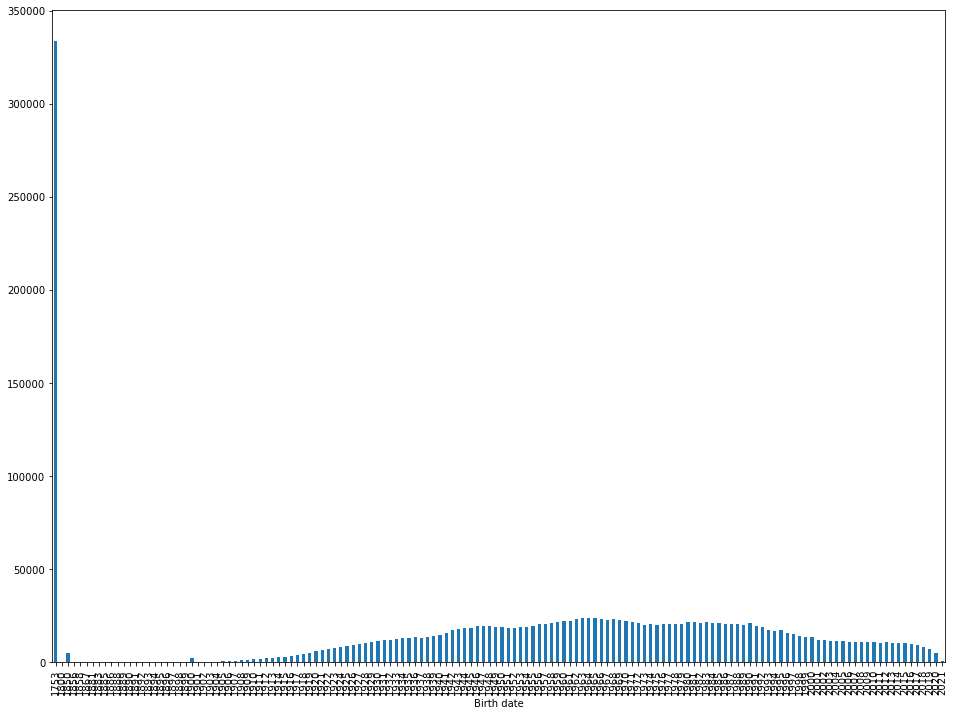

In [46]:
plot_date_histogram_of_col(patient_general_data_df, "Birth date")

In [9]:
# fix temporary misencoding of männlich
patient_general_data_df.loc[patient_general_data_df["Gender"] == "mÃÂ¤nnlich", "Gender"] = "male"

In [10]:
patient_general_data_df.drop(columns=["index"], inplace=True)

## Add patient age based on study end (Age, age)

In [21]:
patient_general_data_df["Age"] = (study_end - patient_general_data_df['Birth date']).astype('<m8[Y]')
patient_general_data_df

,Patient ID,Birth date,Gender,Risk,Age
0,00001238205,1953-01-07,male,pp,67.0
1,00003659119,1930-08-31,male,pp,90.0
2,00000018996,1980-03-10,female,pp,40.0
3,00002456176,1935-06-28,female,pp,85.0
4,00001255975,1753-01-01,NaN,pp,267.0
...,...,...,...,...,...
2004676,00001503350,1753-01-01,NaN,nn,267.0
2004677,00001503364,1753-01-01,NaN,nn,267.0
2004678,00001503386,1753-01-01,NaN,nn,267.0
2004679,00001503392,1753-01-01,NaN,nn,267.0


## Add charlson_weights data (charlson_weighted)

## Add length of stay data (los)

## Add number of rooms (nrooms)

## Add number of stays (stay)

In [68]:
patient_stays_df = pd.read_csv(f"./data/processed/delivery/stats/{now_str}_export/{now_str}_patient_stays.csv", parse_dates=["timestamp_begin", "timestamp_end"], index_col=0)


/home/benelot/miniconda3/envs/vre-spark/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [69]:
patient_stays_df

,patient_id,room_id,timestamp_begin,timestamp_end
0,647,BH Q 116_SAP,2019-07-08 10:00:00,2019-07-09 12:00:00
1,647,BH Q 116_SAP,2019-07-08 10:00:00,2019-07-09 12:00:00
2,647,BH Q 116_SAP,2019-07-08 10:00:00,2019-07-09 12:00:00
3,647,BH Q 116_SAP,2019-07-09 12:00:00,2019-07-09 12:00:00
4,647,BH Q 116_SAP,2019-07-09 12:00:00,2019-07-09 12:00:00
...,...,...,...,...
2785829,90912861,S1_SAP,2019-11-24 10:55:00,2019-11-24 12:30:00
2785830,90912861,S1_SAP,2019-11-24 10:55:00,2019-11-24 12:30:00
2785831,90912861,S1_SAP,2019-11-24 10:55:00,2019-11-24 12:30:00
2785832,90912861,INE BL04_SAP,2019-11-24 13:48:00,2019-11-25 21:00:00


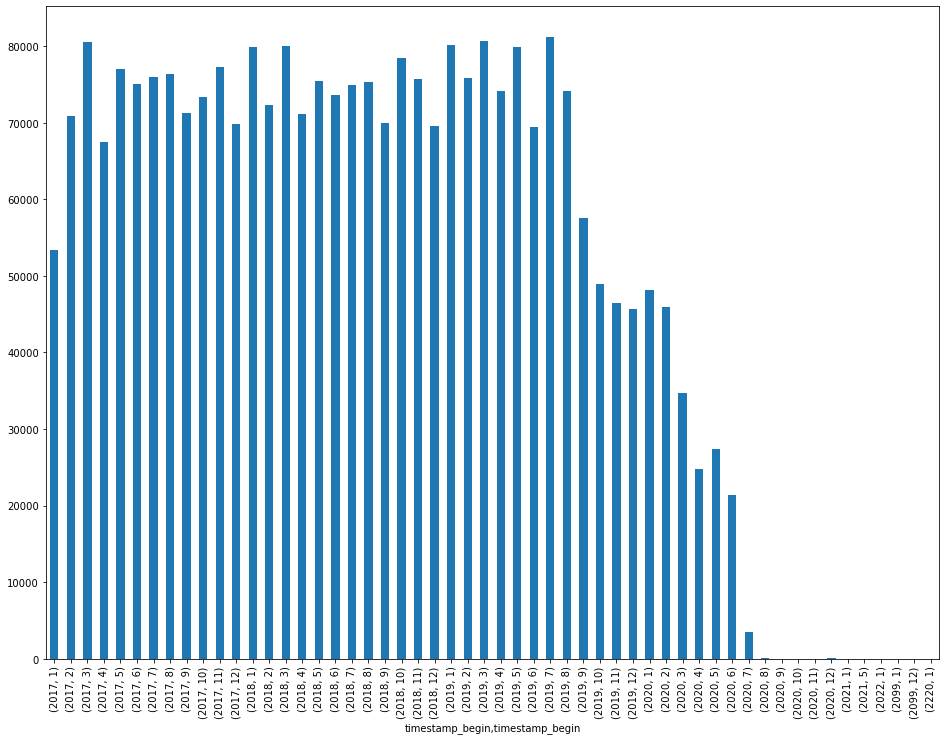

In [70]:
plot_date_histogram_of_col(patient_stays_df, "timestamp_begin", by_month=True)

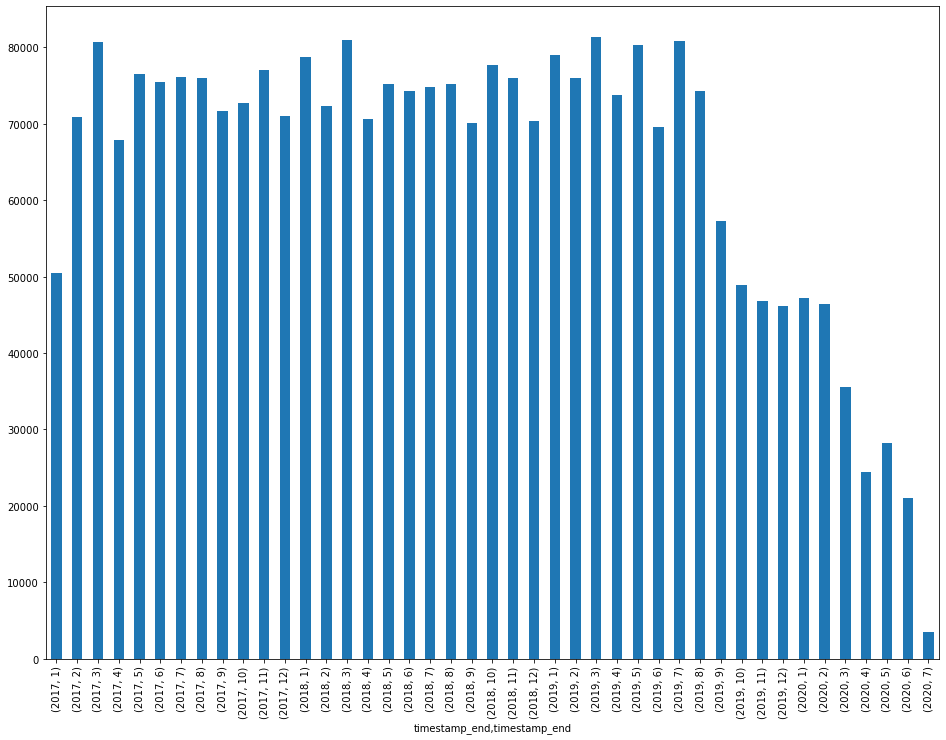

In [71]:
plot_date_histogram_of_col(patient_stays_df, "timestamp_end", by_month=True)

## Add "has_icu_stay" during period" data (has_icu_stay, icu)

In [12]:
patient_icu_data_df = pd.read_csv(f"./data/processed/delivery/stats/{now_str}_export/{now_str}_patient_icu.csv", dtype=str, parse_dates=["From Datetime", "To Datetime"], index_col=0)

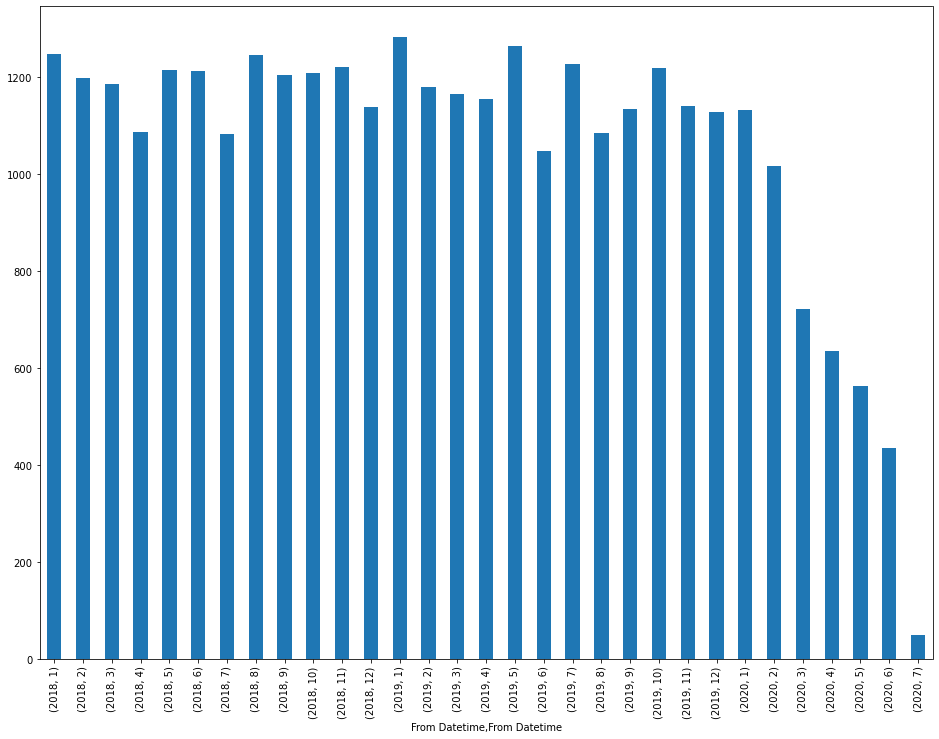

In [33]:
plot_date_histogram_of_col(patient_icu_data_df, "From Datetime", by_month=True)

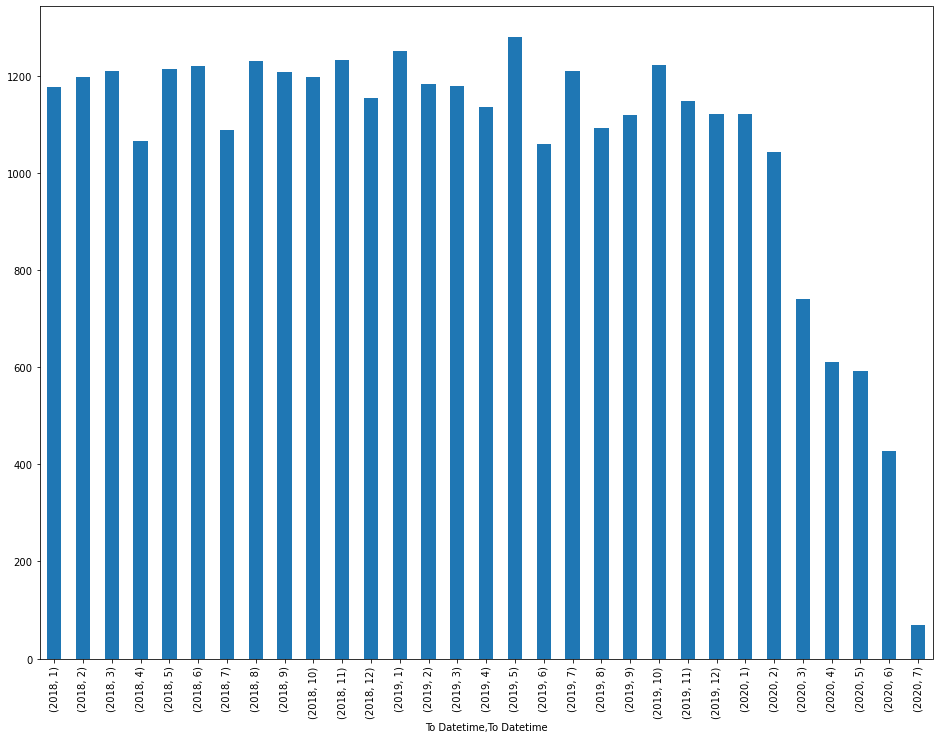

In [34]:
plot_date_histogram_of_col(patient_icu_data_df, "To Datetime", by_month=True)

In [13]:
patient_icu_data_df

,Patient ID,From Datetime,To Datetime,ICU Ward ID
0,00000000981,2018-04-23 13:35:00,2018-04-24 09:30:00,INEGE 2
1,00000001171,2018-06-22 08:25:00,2018-06-22 09:01:00,INEGE 1
2,00000001171,2018-06-22 12:15:00,2018-06-27 18:55:12,INEGE 1
3,00000001171,2018-06-27 18:55:12,2018-07-05 10:00:00,E108-09
4,00000001171,2018-06-27 18:55:12,2018-07-05 10:00:00,E108-09
...,...,...,...,...
46554,00090912454,2019-07-14 14:20:00,2019-07-15 14:32:20,E120-21
46555,00090912454,2019-07-14 14:20:00,2019-07-15 14:32:20,E120-21
46556,00090912454,2019-07-14 14:20:00,2019-07-15 14:32:20,E120-21
46557,00090912861,2019-11-24 13:48:00,2019-11-25 21:00:00,INEBL 1


In [14]:
# filter icu data for study date
patient_icu_data_df = patient_icu_data_df[(patient_icu_data_df["From Datetime"] >= study_start) & (patient_icu_data_df["To Datetime"] <= study_end)]
patient_icu_data_df

,Patient ID,From Datetime,To Datetime,ICU Ward ID
0,00000000981,2018-04-23 13:35:00,2018-04-24 09:30:00,INEGE 2
1,00000001171,2018-06-22 08:25:00,2018-06-22 09:01:00,INEGE 1
2,00000001171,2018-06-22 12:15:00,2018-06-27 18:55:12,INEGE 1
3,00000001171,2018-06-27 18:55:12,2018-07-05 10:00:00,E108-09
4,00000001171,2018-06-27 18:55:12,2018-07-05 10:00:00,E108-09
...,...,...,...,...
46554,00090912454,2019-07-14 14:20:00,2019-07-15 14:32:20,E120-21
46555,00090912454,2019-07-14 14:20:00,2019-07-15 14:32:20,E120-21
46556,00090912454,2019-07-14 14:20:00,2019-07-15 14:32:20,E120-21
46557,00090912861,2019-11-24 13:48:00,2019-11-25 21:00:00,INEBL 1


In [15]:
patient_has_icu_stay_df = patient_icu_data_df["Patient ID"].drop_duplicates().to_frame()
patient_has_icu_stay_df["has_icu_stay"] = 1

In [16]:
patient_has_icu_stay_df

,Patient ID,has_icu_stay
0,00000000981,1
1,00000001171,1
7,00000003794,1
8,00000000507,1
18,00001218115,1
...,...,...
46543,00090911580,1
46544,00090912276,1
46549,00090912730,1
46554,00090912454,1


In [17]:
patient_general_icu_df = pd.merge(patient_general_data_df, patient_has_icu_stay_df, how="left", on="Patient ID")

In [18]:
patient_general_icu_df[patient_general_icu_df["has_icu_stay"] == 1]

,Patient ID,Birth date,Gender,Risk,Age,has_icu_stay
5,00003672018,1950-07-02,male,pp,70.0,1.0
6,00001248766,1961-06-08,female,pp,59.0,1.0
7,00001259776,1753-01-01,NaN,pp,268.0,1.0
10,00002504871,1968-01-31,female,pp,53.0,1.0
12,00002469146,1963-05-29,female,pp,57.0,1.0
...,...,...,...,...,...,...
1919398,00090911580,1950-09-02,male,nn,70.0,1.0
1919539,00090912276,1943-02-05,male,nn,78.0,1.0
1919545,00090912730,1963-06-26,male,nn,57.0,1.0
1921853,00090912454,1947-01-03,male,nn,74.0,1.0


In [19]:
patient_general_icu_df['has_icu_stay'].fillna(value=0, inplace=True)

In [20]:
patient_general_icu_df

,Patient ID,Birth date,Gender,Risk,Age,has_icu_stay
0,00001238205,1953-01-07,male,pp,68.0,0.0
1,00003659119,1930-08-31,male,pp,90.0,0.0
2,00000018996,1980-03-10,female,pp,41.0,0.0
3,00002456176,1935-06-28,female,pp,85.0,0.0
4,00001255975,1753-01-01,NaN,pp,268.0,0.0
...,...,...,...,...,...,...
2004676,00001503350,1753-01-01,NaN,nn,268.0,0.0
2004677,00001503364,1753-01-01,NaN,nn,268.0,0.0
2004678,00001503386,1753-01-01,NaN,nn,268.0,0.0
2004679,00001503392,1753-01-01,NaN,nn,268.0,0.0


## Add number of antibiotics (nantibiotics)

In [50]:
patient_antibiotics_data_df = pd.read_csv(f"./data/processed/delivery/stats/{now_str}_export/{now_str}_patient_antibiotics.csv", parse_dates=["Prescription Date"], index_col=0)


In [51]:
patient_antibiotics_data_df

,Patient ID,Prescription ID,Prescription Date,Medication Name,Medication ATC,Action Type,Action Datetime
0,167,NaN,NaT,NaN,NaN,NaN,NaN
1,353,5345119.0,2018-03-29,Cefuroxim Fresenius i.v. Trockensub 1.5 g (Cef...,J01DC02,Start,2018-03-29 00:00:00
2,353,5345119.0,2018-03-29,Cefuroxim Fresenius i.v. Trockensub 1.5 g (Cef...,J01DC02,Ende,2018-04-01 00:00:00
3,353,7236974.0,2019-07-18,Cefuroxim Fresenius i.v. Trockensub 1.5 g (Cef...,J01DC02,Start,2019-07-18 00:00:00
4,353,7236974.0,2019-07-18,Cefuroxim Fresenius i.v. Trockensub 1.5 g (Cef...,J01DC02,Ende,2019-07-20 00:00:00
...,...,...,...,...,...,...,...
437644,90912764,NaN,NaT,NaN,NaN,NaN,NaN
437645,90912810,NaN,NaT,NaN,NaN,NaN,NaN
437646,90912837,NaN,NaT,NaN,NaN,NaN,NaN
437647,90912861,NaN,NaT,NaN,NaN,NaN,NaN


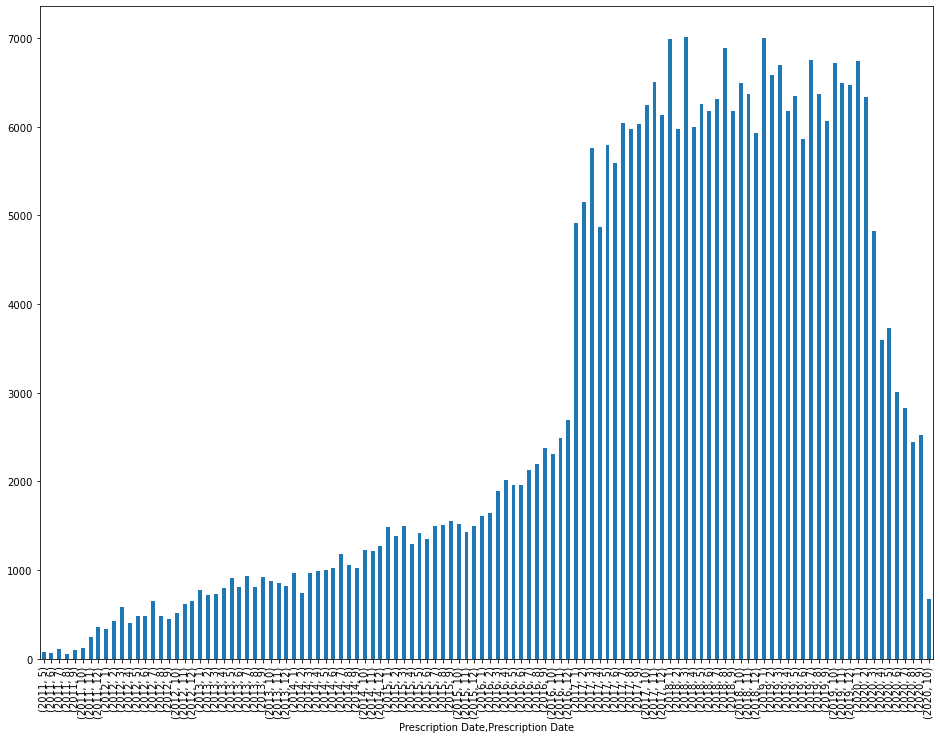

In [52]:
plot_date_histogram_of_col(patient_antibiotics_data_df, "Prescription Date", by_month=True)

## Add surgery indicator and surgery quantity (surg_ind, surgery.quantity)

In [53]:
patient_surgery_qty_df = pd.read_csv(f"./data/processed/delivery/stats/{now_str}_export/{now_str}_patient_surgery_qty.csv", index_col=0)

/home/benelot/miniconda3/envs/vre-spark/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [61]:
patient_surgery_qty_df.sort_values(by="surgery quantity")

,patient_id,surgery quantity
0,51,0
1318640,15994716,0
1318639,15994643,0
1318638,15994627,0
1318637,15994570,0
...,...,...
149382,4049446,123
256848,3626547,125
1262310,13086812,130
1092312,10634495,133


<AxesSubplot:xlabel='surgery quantity'>

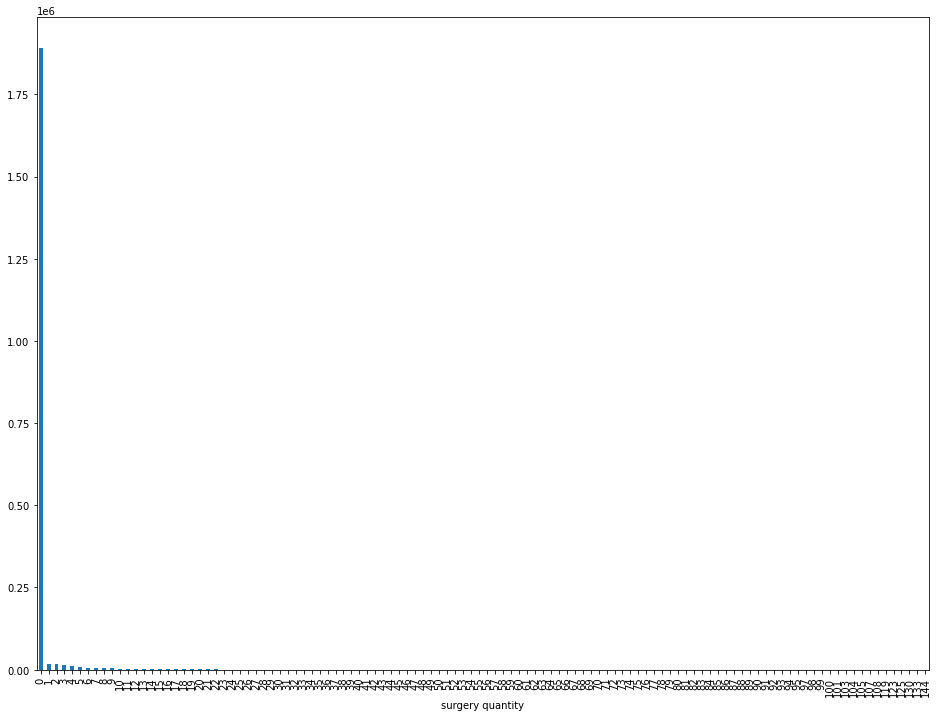

In [64]:
patient_surgery_qty_df["surgery quantity"].groupby(patient_surgery_qty_df["surgery quantity"]).count().plot(kind="bar", figsize=(16,12))